# 1. imports/directories

In [42]:
import os
import glob
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split, Subset
from torchvision import transforms, models
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import shutil

from models.network import Generator, Discriminator, PerceptualLoss
from datasets.InpaintingDataset import SmilingInpaintDataset

In [43]:
os.environ['KMP_DUPLICATE_LIB_OK']='True' # To prevent the kernel from dying.

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_built() else "cpu")

# Paths
dataset_dir = "archive"
img_dir = os.path.join(dataset_dir, "img_align_celeba", "img_align_celeba")
attr_file = os.path.join(dataset_dir, "list_attr_celeba.csv")
landmarks_file = os.path.join(dataset_dir, "list_landmarks_align_celeba.csv")

# 2. Preprocessing

## 2.1 mask and save images

In [ ]:
# load attributes and landmarks
attributes = pd.read_csv(attr_file)
landmarks = pd.read_csv(landmarks_file)

#filter for smiling images
smiling_images = attributes[attributes['Smiling'] == 1]['image_id']

# output directory for masked images
masked_dir = "masked_images"
os.makedirs(masked_dir, exist_ok=True)

# columns for mouth landmarks
mouth_landmarks = ['leftmouth_x', 'leftmouth_y', 'rightmouth_x', 'rightmouth_y']

# mask images
for img_name in tqdm(smiling_images, desc="Processing Smiling Images", unit="image"):
    img_path = os.path.join(img_dir, img_name)
    if not os.path.exists(img_path):
        continue

    # load image
    image = Image.open(img_path)
    draw = ImageDraw.Draw(image)
    
    # get landmarks
    img_landmarks = landmarks[landmarks['image_id'] == img_name]
    if img_landmarks.empty:
        continue

    # extract coordinates for the mouth area
    left_x = int(img_landmarks.iloc[0]['leftmouth_x'])
    left_y = int(img_landmarks.iloc[0]['leftmouth_y'])
    right_x = int(img_landmarks.iloc[0]['rightmouth_x'])
    right_y = int(img_landmarks.iloc[0]['rightmouth_y'])

    # calculate a rectangle for the mask

    # extend 5 pixels upward
    top_left = (left_x, min(left_y, right_y) - 5)
    # extend 10 pixels downward
    bottom_right = (right_x, max(left_y, right_y) + 10)
    
    # draw a black mask over the mouth
    draw.rectangle([top_left, bottom_right], fill="black")

    # save masked image
    masked_image_path = os.path.join(masked_dir, img_name)
    image.save(masked_image_path)

## 2.2 move masked images

In [ ]:
# final directories for organizing images
real_dir = "data/real/smiling"
final_masked_dir = "data/masked/smiling"

# create output directories
os.makedirs(real_dir, exist_ok=True)
os.makedirs(final_masked_dir, exist_ok=True)

# move images
for img_name in tqdm(smiling_images, desc="Moving Images", unit="image"):
    real_img_path = os.path.join(img_dir, img_name)
    masked_img_path = os.path.join("masked_images", img_name)

    # copy real images
    if os.path.exists(real_img_path):
        shutil.copy(real_img_path, real_dir)

    # copy masked images
    if os.path.exists(masked_img_path):
        shutil.copy(masked_img_path, final_masked_dir)

## 2.3 visualize masked images

In [3]:
real_dir = "data/real/smiling"
final_masked_dir = "data/masked/smiling"

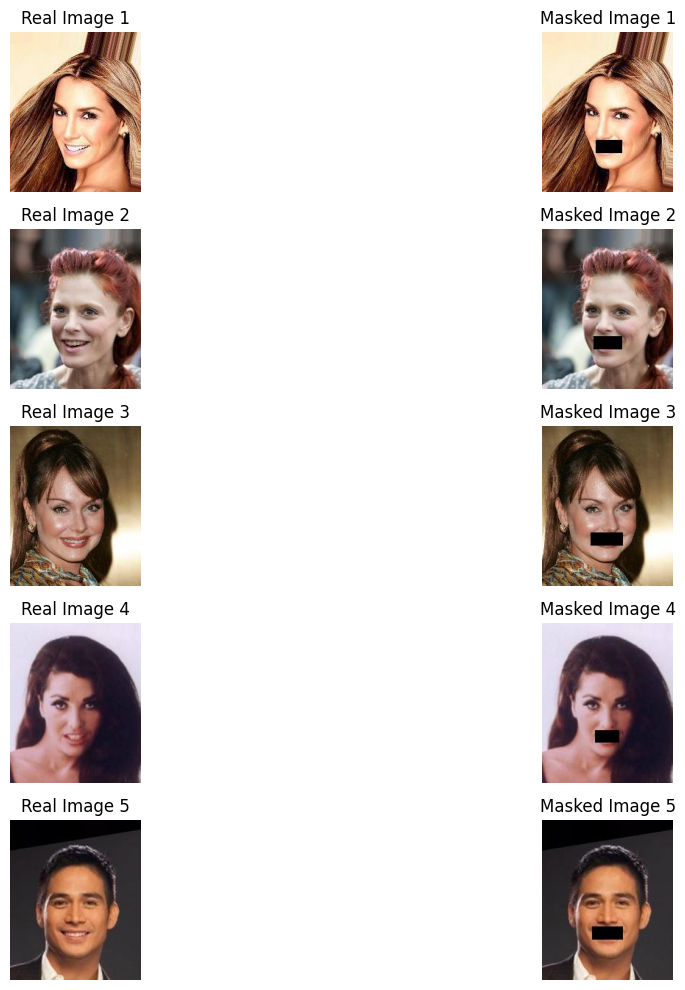

In [4]:
# take the first 5 images
real_images = sorted(os.listdir(real_dir))[:5]

# display images
plt.figure(figsize=(15, 10))
for i, img_name in enumerate(real_images):
    real_img_path = os.path.join(real_dir, img_name)
    masked_img_path = os.path.join(final_masked_dir, img_name)

    real_img = Image.open(real_img_path)
    masked_img = Image.open(masked_img_path)

    plt.subplot(5, 2, i * 2 + 1)
    plt.imshow(real_img)
    plt.title(f"Real Image {i+1}")
    plt.axis("off")

    plt.subplot(5, 2, i * 2 + 2)
    plt.imshow(masked_img)
    plt.title(f"Masked Image {i+1}")
    plt.axis("off")

plt.tight_layout()
plt.show()

# 3. Training

In [44]:
# 1. Define the transform
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)) # Normalizing to [-1, 1]
])

real_root = 'data/real/smiling'
masked_root = 'data/masked/smiling'

# 2. Initialize dataset and dataloader
full_dataset = SmilingInpaintDataset(real_root, masked_root, transform=transform)
total_len = len(full_dataset)
train_len = int(0.8 * total_len)
val_len = int(0.1 * total_len)
test_len = total_len - train_len - val_len
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_len, val_len, test_len])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=4)

# 3. Set device
device = torch.device('mps')

# 4. Initialize models
G = Generator().to(device)
D = Discriminator().to(device)

# 5. Set optimizers
g_optimizer = optim.Adam(G.parameters(), lr=2e-4, betas=(0.5,0.999))
d_optimizer = optim.Adam(D.parameters(), lr=2e-4, betas=(0.5,0.999))

# 6. Set loss functions
adv_loss = nn.BCEWithLogitsLoss().to(device)
l1_loss = nn.L1Loss().to(device)

# 7. Initialize perceptual loss
perceptual_loss = PerceptualLoss().to(device)

print(total_len, train_len, val_len, test_len)

97669 78135 9766 9768


In [45]:
num_epochs = 20
os.makedirs('checkpoints', exist_ok=True)

for epoch in range(num_epochs):
    G.train()
    D.train()
    
    # Wrap the train_loader with tqdm
    pbar = tqdm(train_loader, total=len(train_loader), desc=f"Epoch [{epoch+1}/{num_epochs}]", dynamic_ncols=False, ncols=150)
    
    for i, (masked_img, mask, real_img) in enumerate(pbar):
        masked_img = masked_img.to(device)
        mask = mask.to(device)
        real_img = real_img.to(device)

        # Train Discriminator
        with torch.no_grad():
            fake_img = G(masked_img, mask)
        
        d_optimizer.zero_grad()
        real_pred = D(real_img)
        fake_pred = D(fake_img.detach())
        
        real_label = torch.ones_like(real_pred, device=device)
        fake_label = torch.zeros_like(fake_pred, device=device)
        
        d_real_loss = adv_loss(real_pred, real_label)
        d_fake_loss = adv_loss(fake_pred, fake_label)
        d_loss = (d_real_loss + d_fake_loss) * 0.5
        d_loss.backward()
        d_optimizer.step()

        # Train Generator
        g_optimizer.zero_grad()
        fake_img = G(masked_img, mask)
        fake_pred = D(fake_img)
        g_adv_loss = adv_loss(fake_pred, real_label)
        g_l1_loss = l1_loss(fake_img, real_img)
        g_perc_loss = perceptual_loss(fake_img, real_img)

        g_total_loss = g_adv_loss + 10 * g_l1_loss + 0.1 * g_perc_loss
        g_total_loss.backward()
        g_optimizer.step()

        # Update tqdm description every iteration or every 50 steps
        if (i+1) % 50 == 0:
            pbar.set_postfix({
                "D_Loss": f"{d_loss.item():.4f}",
                "G_Loss": f"{g_total_loss.item():.4f}",
                "Adv": f"{g_adv_loss.item():.4f}",
                "L1": f"{g_l1_loss.item():.4f}",
                "Perc": f"{g_perc_loss.item():.4f}"
            })

    # Validation
    G.eval()
    with torch.no_grad():
        val_loss = 0.0
        val_correct_pixels = 0
        val_total_pixels = 0
        threshold = 0.05  # pixel difference threshold

        for masked_img, mask, real_img in val_loader:
            masked_img = masked_img.to(device)
            mask = mask.to(device)
            real_img = real_img.to(device)

            fake_img = G(masked_img, mask)
            val_loss += l1_loss(fake_img, real_img).item()

            # Convert back to [0,1]
            fake_img_01 = (fake_img + 1) / 2
            real_img_01 = (real_img + 1) / 2

            diff = torch.abs(fake_img_01 - real_img_01)
            correct = (diff < threshold).float()
            val_correct_pixels += correct.sum().item()
            val_total_pixels += correct.numel()

        val_loss = val_loss / len(val_loader)
        val_accuracy = (val_correct_pixels / val_total_pixels) * 100.0
        print(f"\nValidation after epoch {epoch+1}: L1 Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")

    # Save the model every 2 epochs
    if (epoch + 1) % 2 == 0:
        torch.save(G.state_dict(), f"checkpoints/G_epoch_{epoch+1}.pth")
        torch.save(D.state_dict(), f"checkpoints/D_epoch_{epoch+1}.pth")
        print(f"Saved checkpoints at epoch {epoch+1}")


Epoch [1/20]: 100%|███████████████████████████| 9767/9767 [1:01:46<00:00,  2.64it/s, D_Loss=0.5698, G_Loss=1.0789, Adv=0.6321, L1=0.0318, Perc=1.2893]



Validation after epoch 1: L1 Loss: 0.0283, Accuracy: 96.70%


Epoch [2/20]: 100%|███████████████████████████| 9767/9767 [1:02:39<00:00,  2.60it/s, D_Loss=0.5430, G_Loss=0.9812, Adv=0.6524, L1=0.0237, Perc=0.9161]



Validation after epoch 2: L1 Loss: 0.0243, Accuracy: 97.52%
Saved checkpoints at epoch 2


Epoch [3/20]: 100%|███████████████████████████| 9767/9767 [1:05:35<00:00,  2.48it/s, D_Loss=0.5357, G_Loss=1.0446, Adv=0.6883, L1=0.0259, Perc=0.9695]



Validation after epoch 3: L1 Loss: 0.0213, Accuracy: 98.01%


Epoch [4/20]: 100%|███████████████████████████| 9767/9767 [1:06:18<00:00,  2.45it/s, D_Loss=0.5742, G_Loss=0.9511, Adv=0.6804, L1=0.0200, Perc=0.7105]



Validation after epoch 4: L1 Loss: 0.0182, Accuracy: 98.41%
Saved checkpoints at epoch 4


Epoch [5/20]: 100%|█████████████████████████████| 9767/9767 [59:19<00:00,  2.74it/s, D_Loss=0.5271, G_Loss=0.9124, Adv=0.6810, L1=0.0173, Perc=0.5887]



Validation after epoch 5: L1 Loss: 0.0171, Accuracy: 98.66%


Epoch [6/20]: 100%|█████████████████████████████| 9767/9767 [58:29<00:00,  2.78it/s, D_Loss=0.5035, G_Loss=0.8980, Adv=0.6931, L1=0.0149, Perc=0.5595]



Validation after epoch 6: L1 Loss: 0.0146, Accuracy: 98.80%
Saved checkpoints at epoch 6


Epoch [7/20]: 100%|█████████████████████████████| 9767/9767 [58:28<00:00,  2.78it/s, D_Loss=0.5033, G_Loss=0.9100, Adv=0.6929, L1=0.0159, Perc=0.5770]



Validation after epoch 7: L1 Loss: 0.0168, Accuracy: 98.84%


Epoch [8/20]: 100%|█████████████████████████████| 9767/9767 [58:30<00:00,  2.78it/s, D_Loss=0.5037, G_Loss=0.8772, Adv=0.6929, L1=0.0134, Perc=0.5013]



Validation after epoch 8: L1 Loss: 0.0144, Accuracy: 98.89%
Saved checkpoints at epoch 8


Epoch [9/20]: 100%|█████████████████████████████| 9767/9767 [58:21<00:00,  2.79it/s, D_Loss=0.5032, G_Loss=0.8675, Adv=0.6931, L1=0.0131, Perc=0.4357]



Validation after epoch 9: L1 Loss: 0.0142, Accuracy: 98.90%


Epoch [10/20]: 100%|████████████████████████████| 9767/9767 [58:29<00:00,  2.78it/s, D_Loss=0.5032, G_Loss=0.8546, Adv=0.6931, L1=0.0116, Perc=0.4586]



Validation after epoch 10: L1 Loss: 0.0115, Accuracy: 98.96%
Saved checkpoints at epoch 10


Epoch [11/20]:  32%|█████████                   | 3146/9767 [19:06<40:13,  2.74it/s, D_Loss=0.5032, G_Loss=0.8515, Adv=0.6931, L1=0.0114, Perc=0.4402]


KeyboardInterrupt: 

# 4. Evaluation/results 

In [46]:
# Test
G.eval()
test_loss = 0.0
test_correct_pixels = 0
test_total_pixels = 0
threshold = 0.05  # pixel difference threshold

with torch.no_grad():
    for masked_img, mask, real_img in test_loader:
        masked_img = masked_img.to(device)
        mask = mask.to(device)
        real_img = real_img.to(device)

        fake_img = G(masked_img, mask)
        test_loss += l1_loss(fake_img, real_img).item()

        # Convert back to [0,1] for accuracy calculation
        fake_img_01 = (fake_img + 1) / 2
        real_img_01 = (real_img + 1) / 2

        diff = torch.abs(fake_img_01 - real_img_01)
        correct = (diff < threshold).float()
        test_correct_pixels += correct.sum().item()
        test_total_pixels += correct.numel()

test_loss = test_loss / len(test_loader)
test_accuracy = (test_correct_pixels / test_total_pixels) * 100.0
print(f"Test L1 Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")


Test L1 Loss: 0.0135, Test Accuracy: 98.93%


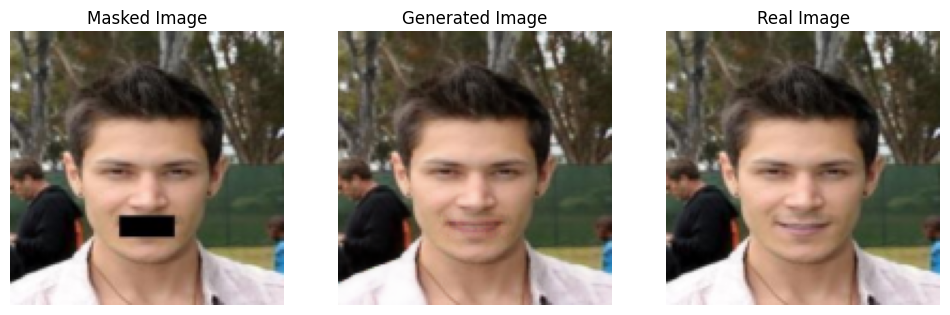

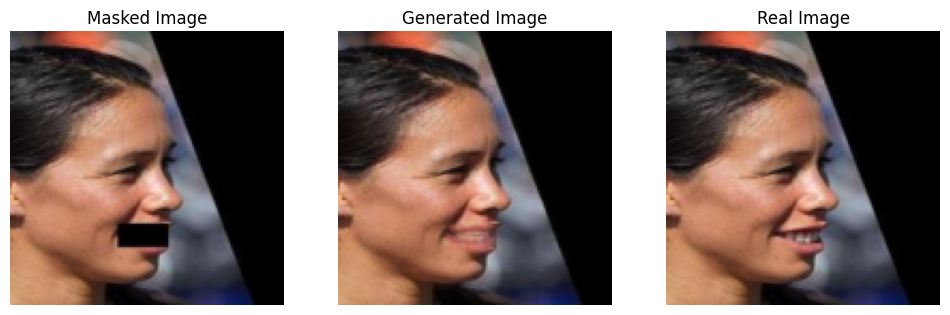

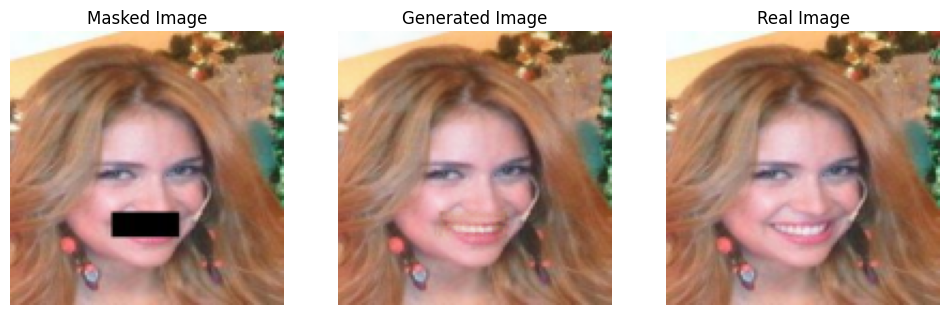

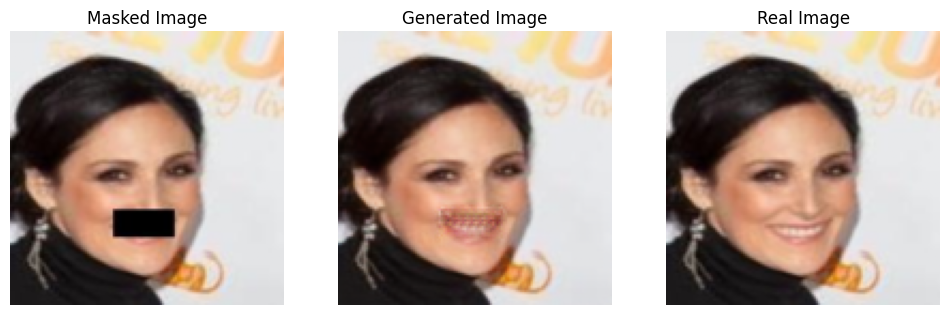

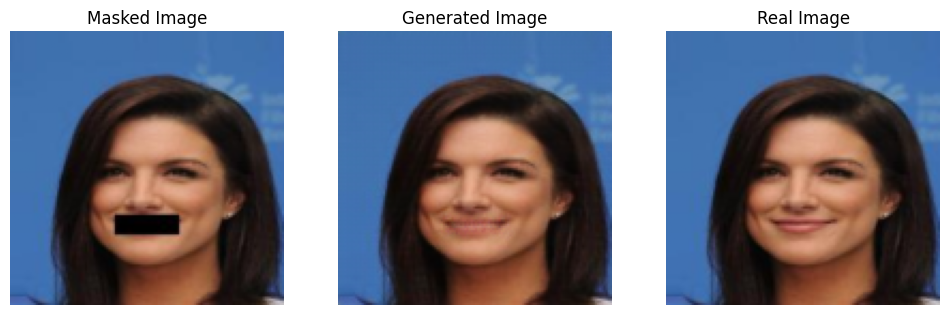

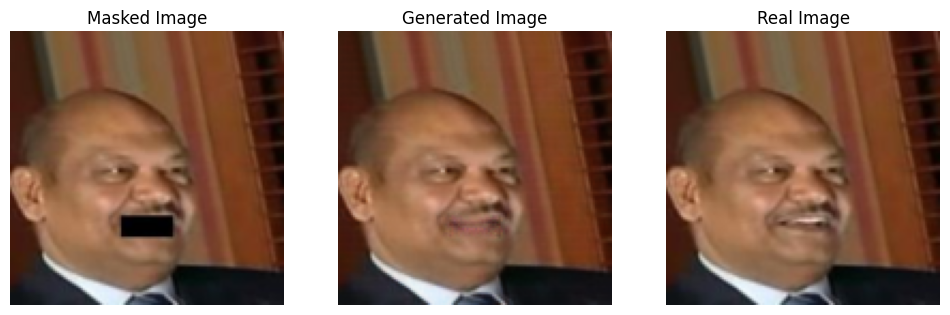

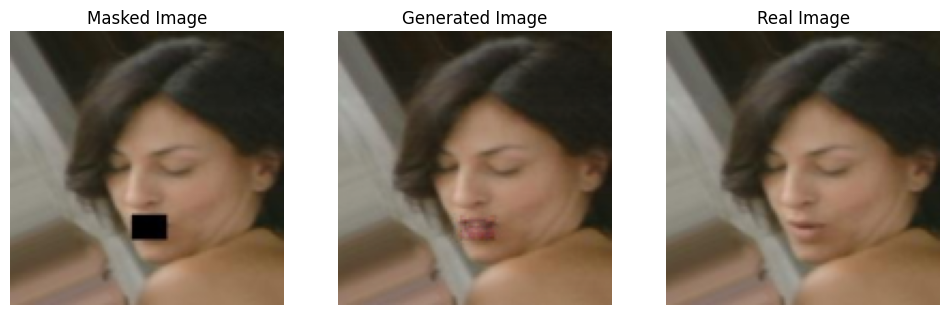

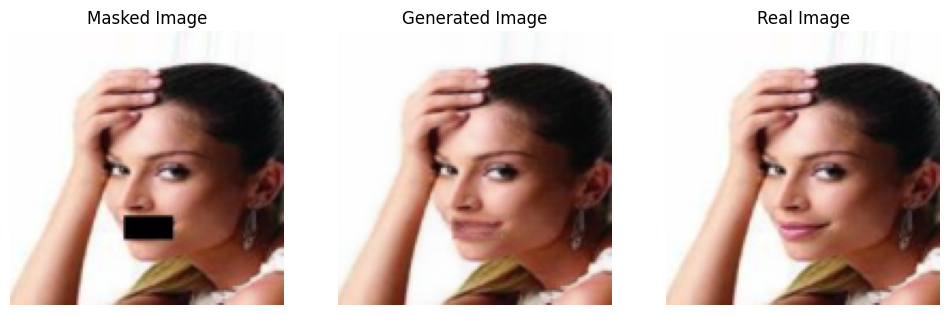

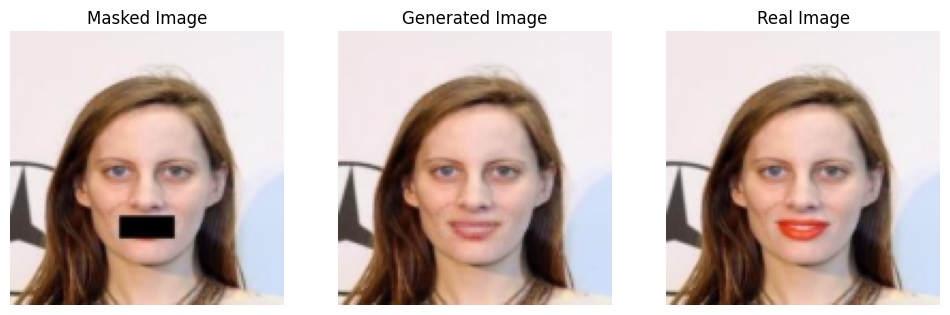

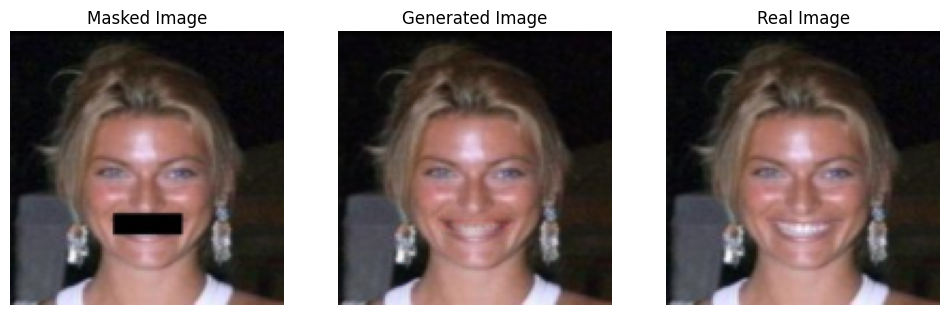

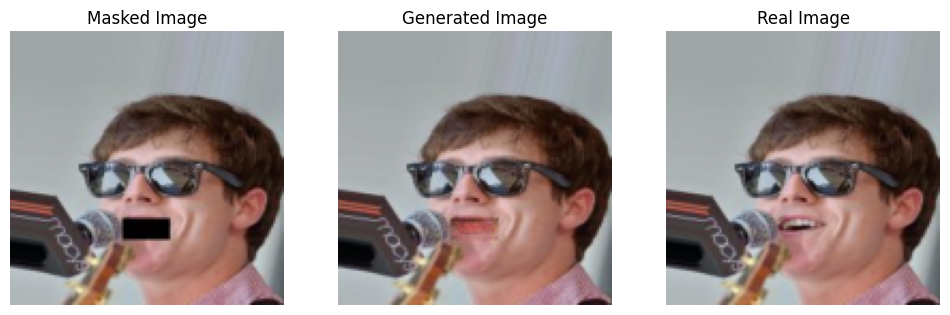

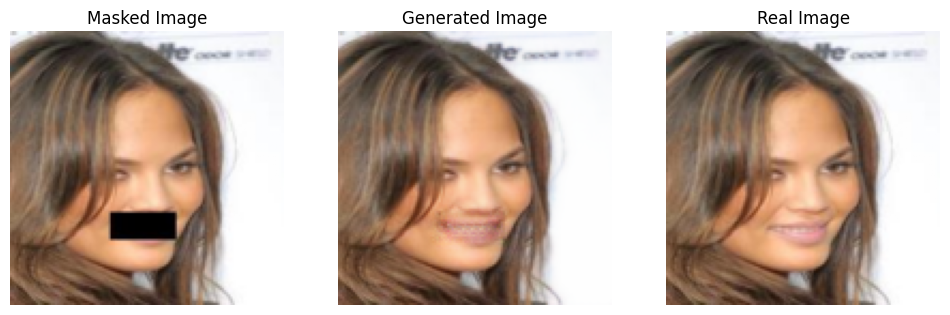

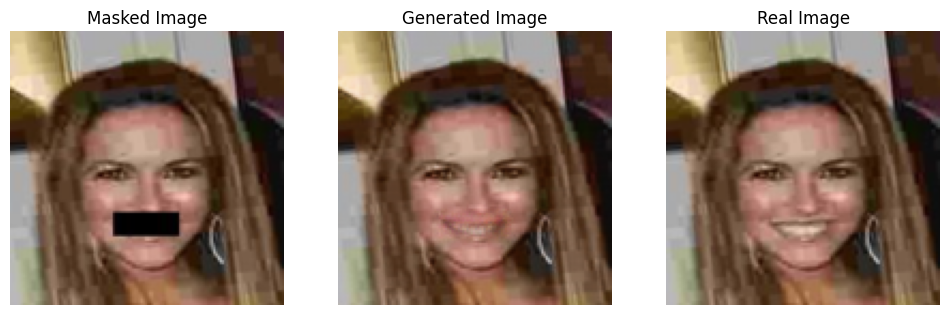

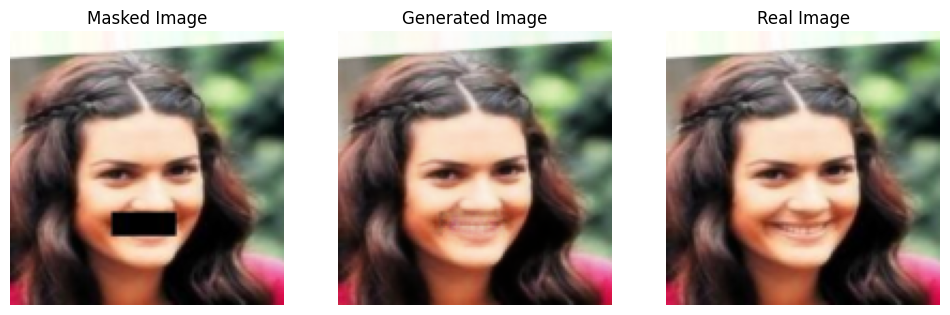

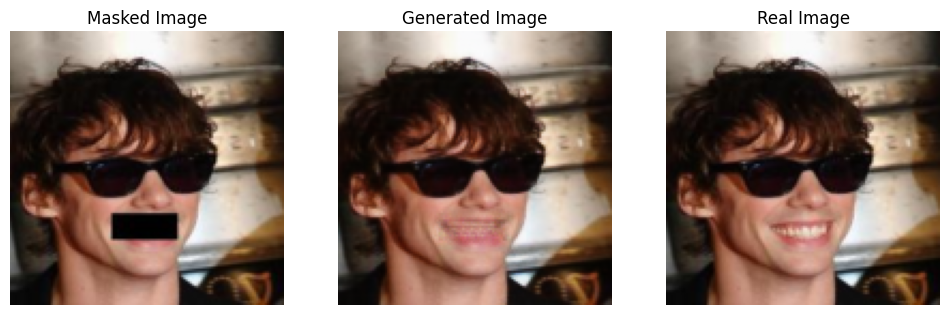

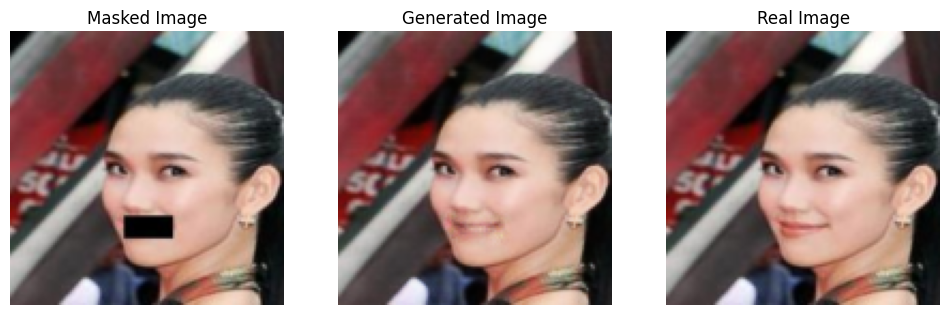

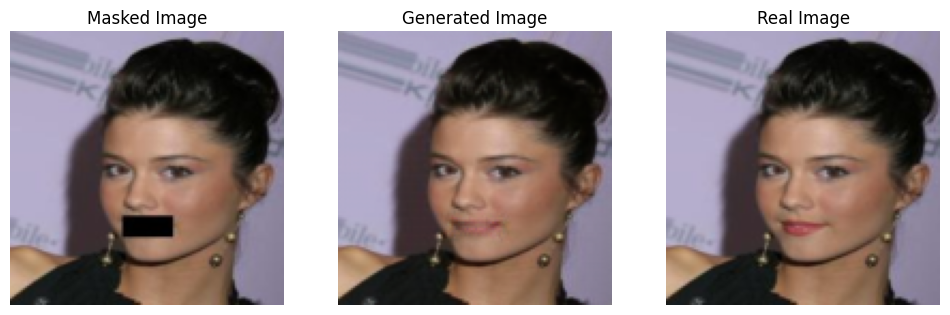

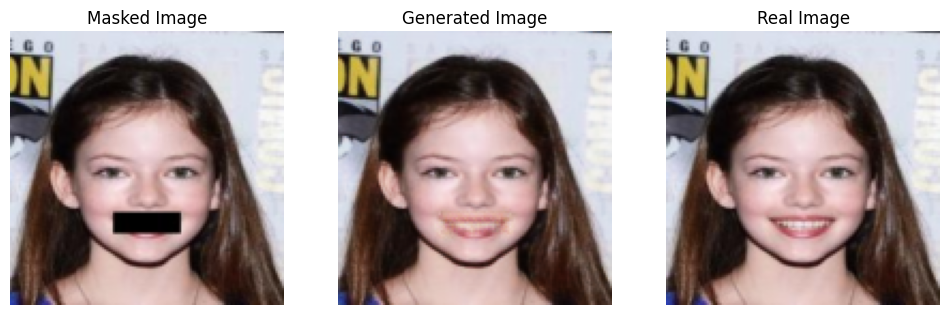

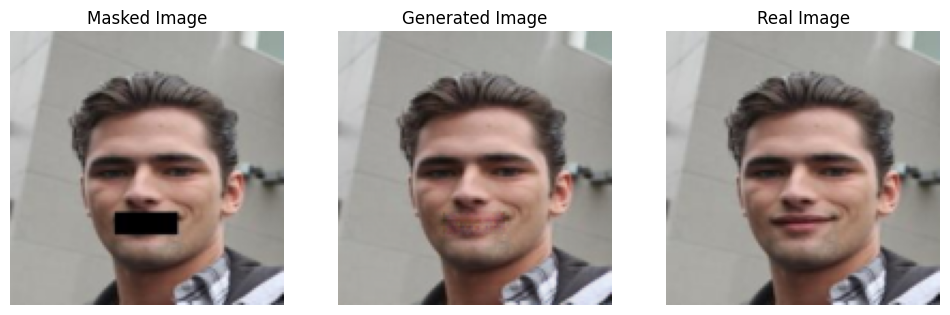

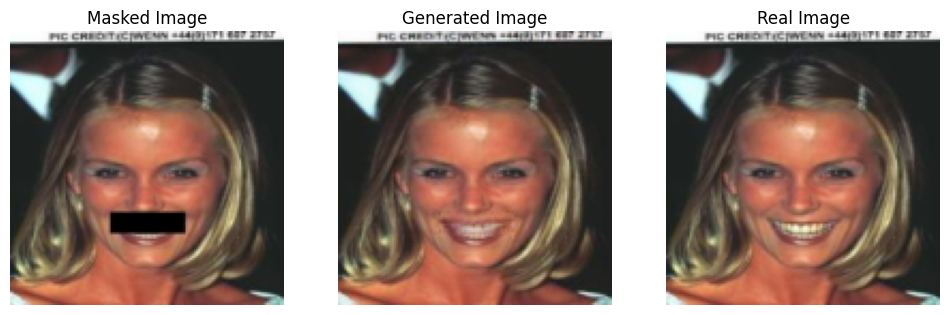

In [61]:
import matplotlib.pyplot as plt
import random

# Example visualization of random test results
G.eval()
examples = 20  # Number of random examples to show

# Create a shuffled list of indices
test_indices = random.sample(range(len(test_dataset)), examples)

# Fetch random images from the test set
with torch.no_grad():
    for idx in test_indices:
        masked_img, mask, real_img = test_dataset[idx]

        # Move data to the device
        masked_img = masked_img.unsqueeze(0).to(device)  # Add batch dimension
        mask = mask.unsqueeze(0).to(device)
        real_img = real_img.unsqueeze(0).to(device)

        # Generate the inpainted image
        fake_img = G(masked_img, mask)

        # Convert back to [0,1] for plotting
        masked_img_01 = (masked_img.cpu().squeeze(0) + 1) / 2
        real_img_01 = (real_img.cpu().squeeze(0) + 1) / 2
        fake_img_01 = (fake_img.cpu().squeeze(0) + 1) / 2

        # Plot original masked image, generated image, and real image
        fig, axes = plt.subplots(1, 3, figsize=(12, 4))
        axes[0].imshow(masked_img_01.permute(1, 2, 0).clamp(0, 1))
        axes[0].set_title('Masked Image')
        axes[0].axis('off')

        axes[1].imshow(fake_img_01.permute(1, 2, 0).clamp(0, 1))
        axes[1].set_title('Generated Image')
        axes[1].axis('off')

        axes[2].imshow(real_img_01.permute(1, 2, 0).clamp(0, 1))
        axes[2].set_title('Real Image')
        axes[2].axis('off')

        plt.show()
